<a href="https://colab.research.google.com/github/jayapat/datascience_projects/blob/main/CIFAR10_Image_Recognition_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Font color = 'pickle'>**Install/Import Libraries**

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [ ]:
# Install wandb and update it to the latest version
if 'google.colab' in str(get_ipython()):
    !pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount google drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from pathlib import Path
import wandb
import os

In [ ]:
%env 'WANDB_NOTEBOOK_NAME' 'jay_hw2.ipynb'
# in the above line we are specyfying the jupyter(colab) notebook name for wandb
# Login to W&B
wandb.login()

env: 'WANDB_NOTEBOOK_NAME'='jay_hw2.ipynb'


True

# <Font color = 'pickle'>**CIFAR10 Dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Categories present in the dataset:

 <font color = 'indianred'>**['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', horse', 'ship', 'truck']**</font>

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks

Let us download the dataset using some built-in functions.

We will first convert the images in the dataset to pytorch tensors using torchvision.transforms and then normalize them.

Next, we will use torchvision.datasets for downloading the CIFAR10 datasets and apply transform that we defines earlier. 

- `trainset` conains the training data
- `testset` contains the testing data

In [ ]:
# This is the path where we will downlaod and save data
if 'google.colab' in str(get_ipython()):
    data_folder = Path('/content/drive/MyDrive/atd_utd_fall/jay_hw2')
else:
    data_folder = Path('G:/My Drive/atd_utd_fall/jay_hw2')

## <Font color = 'pickle'>**Train and Test Dataset**


In [ ]:
# Transform to convert images to pytorch tensors
trans1 = transforms.ToTensor()

# Transform to normalize the data
# The mean and std are based on train subset which we will create below
trans2 = transforms.Normalize((0.49, 0.482, 0.447), (0.247, 0.244, 0.262))
trans = transforms.Compose([trans1, trans2])

# Download the training_validation data (we will create two subsets - trainset and valset frpm this)
train_val_set = torchvision.datasets.CIFAR10(root = data_folder, 
                                             train = True, 
                                             transform = trans, 
                                             download = True,
                                             )

# Download the testing data
testset = torchvision.datasets.CIFAR10(root = data_folder, 
                                            train = False, 
                                            transform = trans, 
                                            download = True)

Files already downloaded and verified
Files already downloaded and verified


## <Font color = 'pickle'>**Split train set to train/validation set**

In [ ]:
def split_dataset(base_dataset, fraction, seed):
    split_a_size = int(fraction * len(base_dataset))
    split_b_size = len(base_dataset) - split_a_size
    return torch.utils.data.random_split(base_dataset, [split_a_size, split_b_size], generator=torch.Generator().manual_seed(seed)
    )

In [ ]:
trainset, validset = split_dataset(train_val_set, 0.8, 42)

In [ ]:
# Since the transforms are not applied, we will manually first divide by 255
# we will then get the mean and std dev 
# the images are still in mumpy with the shape (number of images, H, W, Channels)
# Since we need mean, std dev 
train_data = train_val_set.data[trainset.indices]/255
train_data.shape
print(train_data.mean(axis = (0,1,2)))
print(train_data.std(axis = (0,1,2)))

[0.49171654 0.48256152 0.44711783]
[0.24705465 0.24350537 0.26166664]


## <Font color = 'pickle'>**Check inputs**

In [ ]:
print(type(trainset), type(trainset.dataset), type(trainset.indices), sep ='\n')

<class 'torch.utils.data.dataset.Subset'>
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'list'>


In [ ]:
trainset.indices[0:5]

[37542, 44491, 216, 43688, 41558]

In [ ]:
print(len(trainset), len(trainset.dataset), len(trainset.indices), sep ='\n')

40000
50000
40000


In [ ]:
# Shape of training data
len(trainset.indices), len(validset.indices)

(40000, 10000)

In [ ]:
print(train_val_set.data[trainset.indices].shape)
print(trainset.dataset.data[trainset.indices].shape)

(40000, 32, 32, 3)
(40000, 32, 32, 3)


In [ ]:
train_val_set.data[validset.indices].shape

(10000, 32, 32, 3)

In [ ]:
# Shape of testing data
testset.data.shape

(10000, 32, 32, 3)

In [ ]:
# check the max value of inputs - the transformation are not yet applied.
# the transofrmation are applied iteratively on batches 
# when we craete batch by iterating over dataloader
train_val_set.data[trainset.indices].max()

255

In [ ]:
# check the min value of inputs
train_val_set.data[trainset.indices].min()

0

## <Font color = 'pickle'>**Check Labels**

In [ ]:
# check target values for train set
train_val_targets = torch.tensor(train_val_set.targets)
train_val_targets[trainset.indices].shape

torch.Size([40000])

In [ ]:
# Unique Target values
train_val_targets[trainset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
train_val_targets[validset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
torch.tensor(testset.targets).unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# <Font color = 'pickle'>**Data Loaders**

The next step is to create dataloader for train, valid, and test set using pytorch dataloader. This will be an iterator that will provide dataset in batches.  Let's keep batch size as 256. 

In [ ]:
import cv2 as cv
# Initializing the batch size
batch_size = 256

# Creating data loader for train set
train_loader = torch.utils.data.DataLoader(dataset = trainset, 
                                            batch_size = batch_size, 
                                          shuffle = True, 
                                           drop_last = False)

valid_loader = torch.utils.data.DataLoader(dataset = validset, 
                                            batch_size = batch_size, 
                                            shuffle = False,
                                           drop_last = False)

# Creating data loader for test set
test_loader = torch.utils.data.DataLoader(dataset = testset, 
                                          batch_size = batch_size, 
                                          shuffle = False,
                                          drop_last = False)

In [ ]:
# check number of batches
len(train_loader)

157

In [ ]:
# check total training examples
len(train_loader.dataset)

40000

In [ ]:
# check imputs and outputs 
for input, target in train_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmin input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nstd input value  :{input.std()}')
  print(f'\nshape of targets is :{target.shape}')
  print(f'\ninputs  :{input[0, 0, 5:10, 5:10]}')
  
  break

shape of inputs is :torch.Size([256, 3, 32, 32])

max input value  :2.122950792312622

min input value  :-1.983805775642395

mean input value  :-0.0034254465717822313

std input value  :1.0225069522857666

shape of targets is :torch.Size([256])

inputs  :tensor([[ 3.3421e-01,  2.8658e-01,  2.3895e-01,  5.7236e-01,  1.3344e+00],
        [-1.2622e-01, -1.5083e-02, -1.5083e-02,  7.3113e-01,  1.5091e+00],
        [ 7.9380e-04,  2.5482e-01,  3.1833e-01,  6.6762e-01,  1.3027e+00],
        [ 4.2947e-01,  2.7070e-01,  2.2307e-01,  1.5956e-01,  4.8424e-02],
        [ 3.1833e-01,  3.3421e-01,  1.9132e-01,  1.1193e-01, -1.2622e-01]])


<font size = 5, color = 'indianred' > What values you observe for mean and std for the batch and why? </font>

<font size = 4, color = 'indianred' >
Type Answer Below </font>




#### Values observed for the mean and std are -0.0034254465717822313 and 1.0225069522857666. This is because the we have Transform the data to normalize **data**.

# <Font color = 'pickle'>**Visualize the Data**

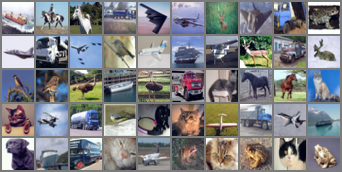

In [ ]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 10)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
images.image

In [ ]:
# Define the values for classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# <font color = 'pickle'> **Functions to implement Softmax**

Now, we will start implementing our Softmax Regression Model from scratch.

We will now create following functions:

- **Model**
- **Loss Function** 
- **One Hot Encoding**
- **Training Loop for 1 epoch**
- **Validation Loop for 1 epoch**
- **Model Training** - repeat the training and validation loops for given number of epochs
- **Function to get the accuracy given the model**

## <Font color = 'pickle'>**Function to define Model**

It has two steps :
- Calculate output as a linerar function of inputs
$$o_k^{(i)}  = \mathbf{x^{(i)}}\mathbf{w_k} ^T+b_k$$
- Apply softmax on output to get probabilities
$$\hat{p_k}^{(i)} = softmax(o_k^{(i)}) = \frac{e^{o_k^{(i)}}}{\sum_{j=1}^{K} e^{o_j^{(i)}}}$$

Softmax operation consists of three steps: 
- Exponentiate each term.
- Sum over each row to get the normalization constant for each example.
- Divide each row by its normalization constant.

This is given by:

We will first define the function for softmax operation.

In [ ]:
def softmax(output):
    """ 
    Function to calculate softmax.
    Input: Tensor.
    Output: Softmax of tensor.
    """

    # Numerator
    num = torch.exp(output)

    # Denominator
    denom = num.sum(1, keepdim=True)

    # Return the softmax value
    return num / denom  

In [ ]:
def model(X, W, b):
    """ 
    Softmax Regression Model.
    Input: Features, Weight, bias
    Output: Predicted labels.
    """

    # Reshape X so that matrix multiplication is possible between Weights and X
    X = X.reshape(-1, W.shape[1])
    
    # Now we will perform the operation to get our equation y = Xw + b
    Y = torch.matmul(X, W.T) + b

    # Now we will return the softmax of our predictions
    return softmax(Y)

## <Font color = 'pickle'>**Loss Function**

We will be using cross-entropy loss.





In [ ]:
def cross_entropy(ypred, y):
    """ 
    Function to calculate Cross Entropy loss.
    Input: Predicted labels and actual labels.
    Output: Loss.
    """ 
    return - torch.log(ypred[range(len(ypred)), y] + 1e-7).mean()

## <Font color = 'pickle'>**One-Hot Encoding- Encode Labels**

A one-hot encoding is a vector with as many components as the labels. The component corresponding to particular instance’s label is set to 1 and all other components are set to 0. 

Suppose we have a dataset with 3 classes `{cat, dog, parrot}`. Now, if an image is a dog, it's one-hot encoded vector will be `{0, 1, 0}`.

One-hot encoded vector for the all the 3 different classes:

cat: {1, 0, 0}

dog: {0, 1, 0}

parrot: {0, 0, 1}

In [ ]:
def one_hot_labels(labels, num_labels, device):
  """ 
  Function to convert labels to one-hot vectors.
  Input: labels, number of labels, device
  
  Output: One-hot encoded labels.
  """


  # Construct a tensor of size : (number of observations, number of labels)
  y = torch.zeros((len(labels), num_labels), device = device)

  # Iterate over labels and create one-hot vectors according to label value
  for i, l in enumerate(labels):
      y[i][l] = 1

  # Return one-hot encoded vector of labels
  return y

## <Font color = 'pickle'>**Function for Training  Loops**

**Model Training** involves five steps: 

- Step 0: Randomly initialize parameters / weights
- Step 1: Compute model's predictions - forward pass
- Step 2: Compute loss
- Step 3: Compute the gradients
- Step 4: Update the parameters
- Step 5: Repeat steps 1 - 4

Model training is repeating this process over and over, for many **epochs**.

We will specify number of ***epochs*** and during each epoch we will iterate over the complete dataset and will keep on updating the parameters.

***Learning rate*** and ***epochs*** are known as hyperparameters. We have to adjust the values of these two based on validation dataset.

We will now create functions for step 1 to 4.

In [ ]:
def train(train_loader, W, b, num_outputs, learning_rate, loss_function, model):

  """ 
  Function for training the model in each epoch
  Input: iterator for train dataset, weights and bias, number of outputs, learning rate,
  loss function, model.
  Output: weights, bias, train loss, train accuracy at end of each epoch
  """

  # Step 0: Randomly initialize parameters / weights - We give this as input to function for first epoch
  # In subsequent epochs the function gets the updated weights from last epoch

  # Training Loop 
  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # Iterate on batches from the dataset using train_loader
  for input_, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)

    # one hot encoding for target variable
    target_encoded = one_hot_labels(targets, num_outputs, device = device)

    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_, W, b)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Get the predicted values
    y_pred = torch.argmax(output, dim = 1)

    # count number of correct predictions
    correct = torch.sum(y_pred == targets)

    # Step 3: Backward pass -Compute the gradients
    error = output - target_encoded
    grad_W = (1/len(input_)) * error.T.mm(input_.reshape(-1, W.shape[1]))
    grad_b = (1/len(input_)) * error.sum()

    # Step 4: Update the parameters
    W -= learning_rate * grad_W 
    b -= learning_rate * grad_b 
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct
  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)
  

  return W, b, train_loss, train_acc

## <Font color = 'pickle'>**Function for Validation Loops**


In [ ]:
def validate(valid_loader, W, b, loss_function, model):

  """ 
  Function for calcuilating loss and prediction for validataion dataset. 
  Input: iterator for validation dataset, estimated weights and bias at the end of epoch in training loop, 
  learning rate,   loss function, model
  Output: val loss and accuracy for each epoch.
  """

  # Validation loop
  # Initialize valid_loss at the he strat of the epoch
  
  running_val_loss = 0
  running_val_correct = 0

  for input_,targets in valid_loader:

    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)

    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_, W, b)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Get the predicted values
    y_pred = torch.argmax(output, dim = 1)

    # count number of correct predictions
    correct = torch.sum(y_pred == targets)

    # Add val loss of a batch 
    running_val_loss += loss.item()

    # Add correct count for each batch
    running_val_correct += correct

  # Calculate mean val loss for the whole dataset for a particular epoch
  val_loss = running_val_loss/len(valid_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  val_acc = running_val_correct/len(valid_loader.dataset)
    
  return val_loss, val_acc

## <Font color = 'pickle'>**Function for Model Training**
    
We will now create a function for step 5 of model training


In [ ]:
def train_loop(W, b, num_outputs, train_loader, valid_loader, model, loss_function, epochs, device):
    
  """ 
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    # Get train loss and accuracy for one epoch
    W, b, train_loss, train_acc = train(train_loader, W, b, num_outputs, learning_rate, loss_function, model)
    valid_loss, valid_acc   = validate(valid_loader, W, b, loss_function, model)
    
    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss})
    wandb.log({f"Train Acc :": train_acc})

    wandb.log({f"Valid Loss :": valid_loss})
    wandb.log({f"Valid Acc :": valid_acc})


    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

## <Font color = 'pickle'>**Function for Accuracy and Predictions**

Now we have final values for weights and bias after training the model. We will use these values to make predictions on the test dataset.

In [ ]:
def get_acc_pred(data_loader, W, b, device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # Iterate over batches from data iterator
  for input_, targets in data_loader:
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)

    # Calculated the predicted labels
    output = model(input_, W, b)

    # Choose the label with maximum probability
    prediction = torch.argmax(output, dim = 1)

    # Add the predicted labels to the array
    predictions = torch.cat((predictions, prediction)) 

    # Add the actual labels to the array
    y = torch.cat((y, targets)) 

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc  

# <Font color = 'pickle'>**Hyperparameters**

In [ ]:
# Initialize a new project
wandb.init(name = "L_0.005", project = 'jay_hw2')

# Initialize number of epochs, learning rate and batch size
learning_rate = 0.005
wandb.log({'learning_rate': learning_rate})
epochs = 10

# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize number of inputs (features: 28 X 28 X 1) and outputs (labels: 10)
num_inputs = 3 *32* 32
num_outputs = 10

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
W = torch.normal(0, 0.05, size = (num_outputs, num_inputs), device = device)

# Initialize bias with zeros
b = torch.zeros(num_outputs, device = device)

loss_function = cross_entropy
model = model

# <Font color = 'pickle'>**Training Model**

In [ ]:
%%wandb 
# Train the model
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(W, b, 
                                                                                          num_outputs, 
                                                                                          train_loader, 
                                                                                          valid_loader, 
                                                                                          model, 
                                                                                          loss_function, 
                                                                                          epochs, 
                                                                                          device)

Epoch : 1 / 10
Train Loss:  2.5828 | Train Accuracy:  23.0000%
Valid Loss:  2.2714 | Valid Accuracy:  27.2700%

Epoch : 2 / 10
Train Loss:  2.1653 | Train Accuracy:  29.2450%
Valid Loss:  2.1048 | Valid Accuracy:  29.5800%

Epoch : 3 / 10
Train Loss:  2.0539 | Train Accuracy:  31.4475%
Valid Loss:  2.0463 | Valid Accuracy:  31.7300%

Epoch : 4 / 10
Train Loss:  1.9940 | Train Accuracy:  32.7275%
Valid Loss:  1.9903 | Valid Accuracy:  33.4600%

Epoch : 5 / 10
Train Loss:  1.9500 | Train Accuracy:  33.9000%
Valid Loss:  1.9689 | Valid Accuracy:  33.4700%

Epoch : 6 / 10
Train Loss:  1.9196 | Train Accuracy:  34.7750%
Valid Loss:  1.9366 | Valid Accuracy:  34.2600%

Epoch : 7 / 10
Train Loss:  1.8941 | Train Accuracy:  35.2600%
Valid Loss:  1.9109 | Valid Accuracy:  35.5200%

Epoch : 8 / 10
Train Loss:  1.8747 | Train Accuracy:  36.0150%
Valid Loss:  1.9100 | Valid Accuracy:  35.0000%

Epoch : 9 / 10
Train Loss:  1.8582 | Train Accuracy:  36.4075%
Valid Loss:  1.8891 | Valid Accuracy:  36

We can observe that with each epoch, our loss is getting reduced.

# <Font color = 'pickle'>**Get Accuracy, Predictions**

In [ ]:
# Get the prediction and accuracy for the test dataset
predictions_test, acc_test = get_acc_pred(test_loader, W, b, device)

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)

Test accuracy tensor(36.2300)


In [ ]:
wandb.log({'Test_Acc': acc_test})

# <Font color = 'pickle'>**Confusion Matrix for Test Data**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:
# Get an array containing actual labels
testing_labels = np.array(testset.targets)

In [ ]:
np.unique(testing_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Log a confusion matrix to W&B
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs = None,
                        y_true = testing_labels,
                        preds = predictions_test.to('cpu').numpy(),
                        class_names = classes)})


In [ ]:
wandb.finish()

Test_Acc,▁
Train Acc :,▁▄▅▆▆▇▇▇██
Train Loss :,█▄▃▂▂▂▁▁▁▁
Valid Acc :,▁▃▅▆▆▇█▇██
Valid Loss :,█▅▄▃▃▂▂▂▁▁
learning_rate,▁
Test_Acc,0.3623
Train Acc :,0.37115
Train Loss :,1.84483
Valid Acc :,0.3587
Valid Loss :,1.87736


# My Report

**- Project URL:** https://wandb.ai/jayapat/jay_hw2

**- Conclusion -** As we can see below in the graph, initially with the learning rate, test data accuracy increases until the learning rate is 0.01. At a learning rate of 0.01 the test accuracy is at pick and equal to 0.3706. Afterthat the learning rate is decreasing with very high rate.

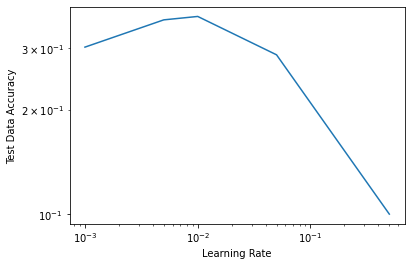

In [ ]:
import matplotlib.pyplot as plt
x = [0.5, 0.05, 0.01, 0.005, 0.001]
y = [.1, .2874, .3706, .3623, .3024]
plt.plot(x , y )
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Data Accuracy')
plt.show()